In [2]:
# ✅ Step 1: Set dataset file path (Colab)
zip_path = '/content/PRCP-1013-WalkRunClass (1).zip'
print("Dataset file path set to:", zip_path)


Dataset file path set to: /content/PRCP-1013-WalkRunClass (1).zip


In [3]:
# ✅ Step 2: Install & Import required libraries
import sys, os
!{sys.executable} -m pip install xgboost --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile, urllib.request

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc


In [4]:
# ✅ Step 3: Load dataset
download_url = 'https://d3ilbtxij3aepc.cloudfront.net/projects/CDS-Capstone-Projects/PRCP-1013-WalkRunClass.zip'

if not os.path.exists(zip_path):
    print("Local dataset not found. Downloading...")
    zip_path = 'PRCP-1013-WalkRunClass_downloaded.zip'
    urllib.request.urlretrieve(download_url, zip_path)

# Extract
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall('PRCP-1013-WalkRunClass_data')

# Find CSV
csv_files = []
for root, dirs, files in os.walk('PRCP-1013-WalkRunClass_data'):
    for f in files:
        if f.lower().endswith(('.csv','.tsv','.txt')):
            csv_files.append(os.path.join(root, f))

if len(csv_files) == 0:
    raise FileNotFoundError("❌ No CSV/TSV found in dataset.")

data_path = csv_files[0]
print("✅ Loading data file:", data_path)
df = pd.read_csv(data_path)
print("✅ Data loaded. Shape:", df.shape)
df.head()


Local dataset not found. Downloading...
✅ Loading data file: PRCP-1013-WalkRunClass_data/Data/walkrun.csv
✅ Data loaded. Shape: (88588, 11)


,date,time,username,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,2017-6-30,13:51:15:847724020,viktor,0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,2017-6-30,13:51:16:246945023,viktor,0,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,2017-6-30,13:51:16:446233987,viktor,0,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,2017-6-30,13:51:16:646117985,viktor,0,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,2017-6-30,13:51:16:846738994,viktor,0,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922


In [5]:
# ✅ Step 4: Preprocessing (Numeric labels: 0 = walk, 1 = run)
df_proc = df.copy()
df_proc.columns = [c.strip() for c in df_proc.columns]

if 'activity' not in df_proc.columns:
    raise KeyError("Target column 'activity' not found in dataset.")

print("Original activity labels:", df_proc['activity'].unique())
df_proc['label'] = df_proc['activity'].astype(int)

# Select features
features = [c for c in df_proc.columns if any(x in c.lower() for x in ['acceleration', 'accel', 'gyro'])]

# Impute missing values
for c in features:
    if df_proc[c].isnull().sum() > 0:
        df_proc[c] = df_proc[c].fillna(df_proc[c].median())

# Encode categorical if needed
cat_cols = [c for c in ['username','wrist'] if c in df_proc.columns]
for c in cat_cols:
    df_proc[c] = df_proc[c].astype(str).fillna('unknown')
    le = LabelEncoder()
    df_proc[c+'_enc'] = le.fit_transform(df_proc[c])

final_features = features + [c+'_enc' for c in cat_cols]
final_features = [f for f in final_features if f in df_proc.columns]

X = df_proc[final_features]
y = df_proc['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Preprocessing complete. Train shape:", X_train.shape, "Test shape:", X_test.shape)


Original activity labels: [0 1]
✅ Preprocessing complete. Train shape: (70870, 8) Test shape: (17718, 8)


In [6]:
# ✅ Step 5: Train multiple models
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    print(f"\n📊 {name} Results:")
    print(classification_report(y_test, y_pred, target_names=['Walk','Run']))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }

results = {}

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
results['Logistic Regression'] = evaluate_model(lr, X_test_scaled, y_test, 'Logistic Regression')

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
results['Random Forest'] = evaluate_model(rf, X_test, y_test, 'Random Forest')

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
results['XGBoost'] = evaluate_model(xgb_model, X_test, y_test, 'XGBoost')

# MLP
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
mlp.fit(X_train_scaled, y_train)
results['MLP'] = evaluate_model(mlp, X_test_scaled, y_test, 'MLP')

pd.DataFrame(results).T



📊 Logistic Regression Results:
              precision    recall  f1-score   support

        Walk       0.83      0.91      0.87      8845
         Run       0.90      0.82      0.86      8873

    accuracy                           0.86     17718
   macro avg       0.87      0.86      0.86     17718
weighted avg       0.87      0.86      0.86     17718

Confusion Matrix:
 [[8055  790]
 [1621 7252]]

📊 Random Forest Results:
              precision    recall  f1-score   support

        Walk       0.99      0.99      0.99      8845
         Run       0.99      0.99      0.99      8873

    accuracy                           0.99     17718
   macro avg       0.99      0.99      0.99     17718
weighted avg       0.99      0.99      0.99     17718

Confusion Matrix:
 [[8780   65]
 [  78 8795]]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:37:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 XGBoost Results:
              precision    recall  f1-score   support

        Walk       0.99      0.99      0.99      8845
         Run       0.99      0.99      0.99      8873

    accuracy                           0.99     17718
   macro avg       0.99      0.99      0.99     17718
weighted avg       0.99      0.99      0.99     17718

Confusion Matrix:
 [[8791   54]
 [  72 8801]]

📊 MLP Results:
              precision    recall  f1-score   support

        Walk       0.99      0.99      0.99      8845
         Run       0.99      0.99      0.99      8873

    accuracy                           0.99     17718
   macro avg       0.99      0.99      0.99     17718
weighted avg       0.99      0.99      0.99     17718

Confusion Matrix:
 [[8794   51]
 [  64 8809]]


,accuracy,precision,recall,f1
Logistic Regression,0.863924,0.901766,0.817311,0.857464
Random Forest,0.991929,0.992664,0.991209,0.991936
XGBoost,0.992889,0.993902,0.991885,0.992893
MLP,0.993509,0.994244,0.992787,0.993515


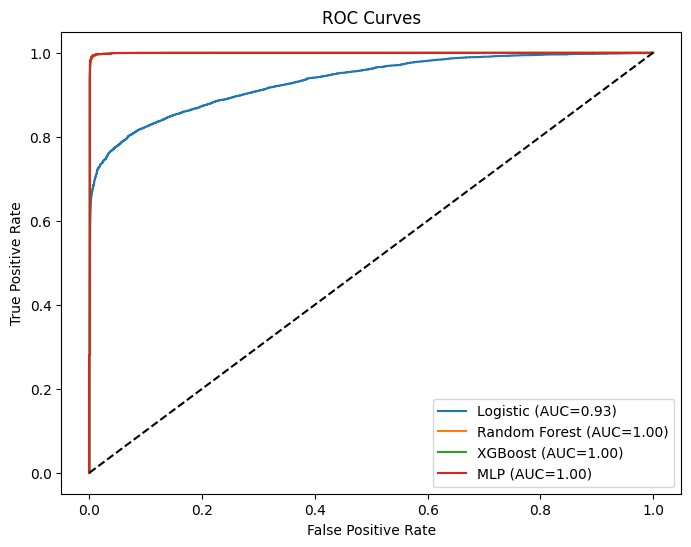

In [7]:
# ✅ Step 6: ROC Curves
plt.figure(figsize=(8,6))

for name, model, X_t in [('Logistic', lr, X_test_scaled),
                         ('Random Forest', rf, X_test),
                         ('XGBoost', xgb_model, X_test),
                         ('MLP', mlp, X_test_scaled)]:
    try:
        y_proba = model.predict_proba(X_t)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.2f})')
    except Exception as e:
        print(f"Skipped ROC for {name}: {e}")

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()
